In [1]:
import numpy as np
from sklearn import preprocessing
import re
import os
import matplotlib.pyplot as plt
from sklearn import ensemble
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [2]:
numb_feat='484'
exp_name='gap_och_1'
feat_type='bob'
enert= np.load('../../data_features/och_data/gap_ener_OCH.npy')
G= np.load('../../data_features/och_data/bob_OCH_484.npy')
numb_atoms= np.load('../../data_features/och_data/number_of_atoms_per_structure_OCH.npy')
g_st= preprocessing.MaxAbsScaler().fit_transform(G)
print '*********************'
print 'g_st ', g_st.shape
print 'enert ', enert.shape
np.save('g_scaled_%s_%s_%s'%(feat_type,numb_feat,exp_name), g_st)

*********************
g_st  (50592, 484)
enert  (50592,)


In [3]:
#G_scaled= g_st[:20000,:]
#E=np.reshape(enert[:20000],(len(enert[:20000]),1))
G_scaled= g_st
E=np.reshape(enert,(len(enert),1))
print E.shape
print G_scaled.shape

mixer= np.array(range(G_scaled.shape[0]))
for _ in range(10000):
    np.random.shuffle(mixer)
n= int(len(mixer)*0.75) # marking the 90%
G_train_scaled= G_scaled[mixer[:n]]
G_vali_scaled= G_scaled[mixer[n:]]
E_train= E[mixer[:n]]
E_vali= E[mixer[n:]]
trai_id= mixer[:n]
vali_id= mixer[n:]
print 'G_train_scaled->', G_train_scaled.shape
print 'G_vali_scaled->', G_vali_scaled.shape
print 'E_train->', E_train.shape
print 'E_vali->', E_vali.shape
np.save('E_targ_%s_%s_%s'%(feat_type,numb_feat,exp_name), E)
np.save('trai_id_%s_%s_%s'%(feat_type,numb_feat,exp_name), trai_id)
np.save('vali_id_%s_%s_%s'%(feat_type,numb_feat,exp_name), vali_id)

(50592, 1)
(50592, 484)
G_train_scaled-> (37944, 484)
G_vali_scaled-> (12648, 484)
E_train-> (37944, 1)
E_vali-> (12648, 1)


In [4]:
#'gap_och_1'
params = {'n_estimators': 600, 'max_depth': 6, 'min_samples_split': 3,
          'learning_rate': 0.1090, 'loss': 'ls', 'min_samples_leaf':3}  #val MSE: 7.0932 MAE 1.4610
#tra MSE: 1.0362 MAE 0.6638

clf = ensemble.GradientBoostingRegressor(**params)

clf.fit(G_train_scaled, E_train)
mse = mean_squared_error(E_vali, clf.predict(G_vali_scaled))
mae= mean_absolute_error(E_vali, clf.predict(G_vali_scaled))
print("val MSE: %.4f MAE %.4f" % (mse,mae))
mse = mean_squared_error(E_train, clf.predict(G_train_scaled))
mae= mean_absolute_error(E_train, clf.predict(G_train_scaled))
print("tra MSE: %.4f MAE %.4f" % (mse,mae))

/home/accounts/zeledon/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


val MSE: 0.0001 MAE 0.0075
tra MSE: 0.0000 MAE 0.0036


In [5]:
mse = mean_squared_error(E_vali, clf.predict(G_vali_scaled))
mae= mean_absolute_error(E_vali, clf.predict(G_vali_scaled))
print("val MSE: %.7f MAE %.5f" % (mse,mae))
mse = mean_squared_error(E_train, clf.predict(G_train_scaled))
mae= mean_absolute_error(E_train, clf.predict(G_train_scaled))
print("tra MSE: %.7f MAE %.5f" % (mse,mae))

val MSE: 0.0001031 MAE 0.00748
tra MSE: 0.0000208 MAE 0.00357


In [6]:
Ep= clf.predict(g_st)
print Ep.shape
print E.shape

Et= np.squeeze(E)
print Et.shape

print numb_atoms.shape

diff_abs_vali= np.abs(np.divide(np.subtract(Et[vali_id], Ep[vali_id]),numb_atoms[vali_id]))#hartree/atom

diff_abs_trai= np.abs(np.divide(np.subtract(Et[trai_id], Ep[trai_id]),numb_atoms[trai_id]))#hartree/atom

(50592,)
(50592, 1)
(50592,)
(50592,)


In [8]:
diff_abs_vali_kcal_mol= np.multiply(diff_abs_vali, 627.55)#kcal/mol

diff_abs_trai_kcal_mol= np.multiply(diff_abs_trai, 627.55)#kcal/mol

print np.max(diff_abs_vali_kcal_mol), np.max(diff_abs_trai_kcal_mol)

print np.average(diff_abs_vali_kcal_mol), np.average(diff_abs_trai_kcal_mol)

3.6755577931 2.30494059912
0.254699257237 0.118768180437


In [10]:
diff_abs= np.abs(np.divide(np.subtract(Et, Ep),numb_atoms))#hartree/atom
diff_abs_kcal_mol= np.multiply(diff_abs, 627.55)#kcal/mol
np.save('E_pred_%s_%s_%s'%(feat_type,numb_feat,exp_name), Ep)
np.save('diff_abs_kcal_mol_%s_%s_%s'%(feat_type,numb_feat,exp_name), diff_abs_kcal_mol)

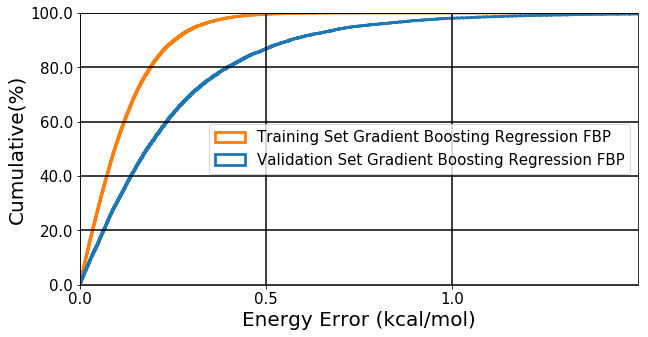

In [9]:
fig, ax = plt.subplots(figsize=(10, 5))
n, bins, patches = ax.hist([diff_abs_vali_kcal_mol, diff_abs_trai_kcal_mol], 5000, normed=1, histtype='step',
                           cumulative=True,linewidth=2.8, label=['Validation Set Gradient Boosting Regression FBP',\
                                                   'Training Set Gradient Boosting Regression FBP'])

#ax.grid(True, linewidth=10)
#ax.legend(loc='lower right')
lg = ax.legend( loc='center right', fontsize= 15)
ax.grid(True, linewidth=10)
ax.set_ylim(0.0,1.00)
ax.set_xlim(0.0,1.5)
ax.set_xticks(np.arange(0.0,1.5,0.5))
ax.set_xticklabels(np.arange(0.0,1.5,0.5))
ax.set_yticks(np.arange(0.0,1.05,0.2))
ax.set_yticklabels(np.arange(0.0,101.0,20.0))
ax.xaxis.set_tick_params(labelsize=15) 
ax.yaxis.set_tick_params(labelsize=15) 
ax.grid(color='k', linestyle='-', linewidth=1.5)
ax.grid(color='k', linestyle='-', linewidth=1.5)
#ax.set_title('CO1214 structures')
ax.set_xlabel('Energy Error (kcal/mol)', fontsize=20)
ax.set_ylabel('Cumulative(%)', fontsize=20)
plt.savefig('imgage_comulative_error_CO14.pdf', format='pdf')
plt.show()

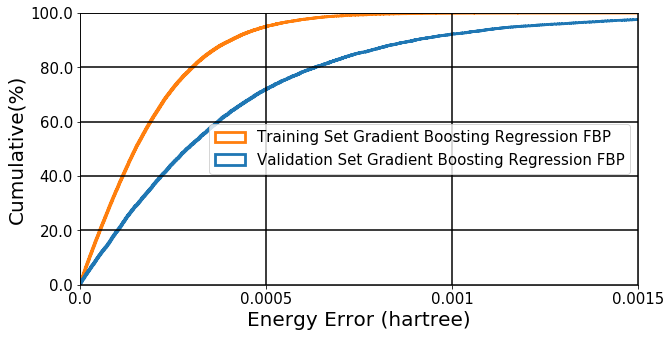

In [7]:
fig, ax = plt.subplots(figsize=(10, 5))
n, bins, patches = ax.hist([diff_abs_vali, diff_abs_trai], 5000, normed=1, histtype='step',
                           cumulative=True,linewidth=2.8, label=['Validation Set Gradient Boosting Regression FBP',\
                                                   'Training Set Gradient Boosting Regression FBP'])

#ax.grid(True, linewidth=10)
#ax.legend(loc='lower right')
lg = ax.legend( loc='center right', fontsize= 15)
ax.grid(True, linewidth=10)
ax.set_ylim(0.0,1.00)
ax.set_xlim(0.0,0.0005)
ax.set_xticks(np.arange(0.0,0.002,0.0005))
ax.set_xticklabels(np.arange(0.0,0.002,0.0005))
ax.set_yticks(np.arange(0.0,1.05,0.2))
ax.set_yticklabels(np.arange(0.0,101.0,20.0))
ax.xaxis.set_tick_params(labelsize=15) 
ax.yaxis.set_tick_params(labelsize=15) 
ax.grid(color='k', linestyle='-', linewidth=1.5)
ax.grid(color='k', linestyle='-', linewidth=1.5)
#ax.set_title('CO1214 structures')
ax.set_xlabel('Energy Error (hartree)', fontsize=20)
ax.set_ylabel('Cumulative(%)', fontsize=20)
plt.savefig('imgage_comulative_error_CO14.pdf', format='pdf')
plt.show()

In [5]:
np.save('E_pred_%s_%s_%s'%(feat_type,numb_feat,exp_name), clf.predict(g_st))

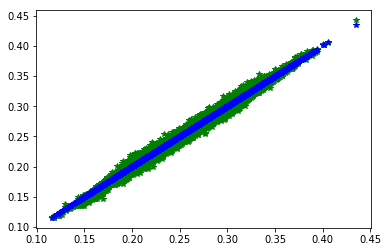

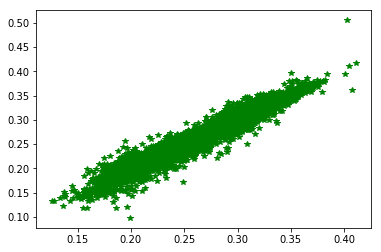

MSE: 0.0000


In [6]:
Ebr_vali= clf.predict(G_vali_scaled)

Ebr_train= clf.predict(G_train_scaled)

plt.plot(Ebr_train, np.squeeze(E_train), '*g', Ebr_train, Ebr_train, '*b')
plt.show()

plt.plot(Ebr_vali, np.squeeze(E_vali), '*g')#, Ebr_vali, Ebr_vali, '*b')
plt.show()

mse = mean_squared_error(E_train, clf.predict(G_train_scaled))
print("MSE: %.4f" % mse)

1.33247981823
1.07495264268e-05
0.134044541276


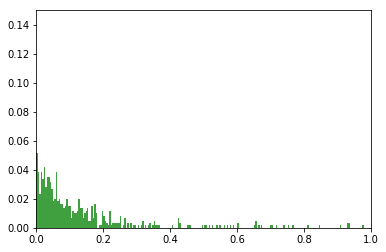

In [8]:
diff_vali= np.abs(np.subtract(Ebr_vali, np.squeeze(E_vali)))
print np.max(diff_vali)
print np.min(diff_vali)
diff_vali_aver= np.average(diff_vali)
print diff_vali_aver

n, bins, patches = plt.hist(diff_vali, 300, facecolor='g', alpha=0.75)
plt.axis([0.0, 1.0, 0, 0.15])
for item in patches:
    item.set_height(item.get_height()/sum(n))
plt.show()

In [8]:
print E_vali.shape
E_vali1d= np.squeeze(E_vali)

(240, 1)


In [9]:
E_b= clf.predict(G_vali_scaled)
print E_b.shape

(240,)


In [10]:
print np.average(np.abs(np.subtract(E_vali1d, E_b)))

0.020570270253


In [65]:
np.save('../analysis/diff_vali_grad_bost_X_oni_48', diff_vali)

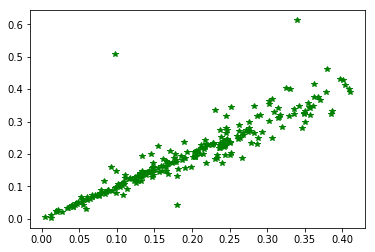

In [12]:
plt.plot(Ebr_vali, np.squeeze(E_vali), '*g')
plt.show()

In [12]:
np.save('g_vali_scaled', G_vali_scaled)
np.save('E_vali', E_vali)
np.save('g_trai_scaled', G_train_scaled)
np.save('E_trai', E_train)
np.save('E_vali_pred', clf.predict(G_vali_scaled))

In [13]:
np.save('E_vali_pred', clf.predict(G_vali_scaled))